# Interpetable YOLOv8 Demo on BR35H Dataset

In [1]:
import os
import torch
from PIL import Image, ImageDraw, ExifTags
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from yolov8_interpretable import InterpretableYOLOTest

In [2]:
def load_model(model_path, model_class=None):
    # loading a custom model
    model = torch.load(model_path)
    model =  model['model'].float()
    model.eval()  # Set the model to evaluation mode
    return model

# Function to get the bounding box from the label file
def get_bounding_box_from_label(image_name, label_dir):
    label_path = os.path.join(label_dir, image_name.replace('.jpg', '.txt'))
    with open(label_path, 'r') as file:
        label = file.readline().strip().split()
    class_id, x_center, y_center, width, height = map(float, label)

    return [x_center, y_center, width, height]

def draw_bounding_box(image, bbox, target_size=(225, 225), original_size=(640, 640), color="red"):
    draw = ImageDraw.Draw(image)
    orig_width, orig_height = original_size
    target_width, target_height = target_size
    size = original_size[0]
    # YOLO format: [x_center, y_center, width, height]
    x_center, y_center, width, height = bbox


    x_center *= size
    y_center *= size
    width *= size
    height *= size



    x1 = x_center - (width / 2)
    y1 = y_center - (height / 2)
    x2 = x_center + (width / 2)
    y2 = y_center + (height / 2)

    draw.rectangle([x1, y1, x2, y2], outline=color, width=2)
    return image


label_dir = '/home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/train/labels' 

In [3]:
data_yaml_path = '/home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/data.yaml'
weights_path = '/home/alan/Documents/YOLOV8_interpretable/YOLOv8_weights/best.pt'
weights = load_model(weights_path, model_class=None)
target_layer_index = 210

In [4]:
model = InterpretableYOLOTest(data_yaml_path, model=weights, target_layer_index=target_layer_index, pca_components=30)
#model.calculate_pearson_correlation()

Collected features for 500 samples from layer at index '210'.
PCA reduced dimensions to 30 components.
complete


In [18]:
inference_file = 'y737.jpg' #change this to perform inference on different images
img_num = ''
for i in range(len(inference_file)):
    if(inference_file[i].isdigit()):
        img_num += inference_file[i]
image_path = '/home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/test/images/' + inference_file
k = 6
result = model.single_image_inference(image_path, k=k)
print(result)

/home/alan/Documents/Dataset_1/brain-tumor-detection-dataset/Br35H-Mask-RCNN/test/images/y737.jpg
{'model_prediction': 0, 'confidence_score': 0.7267082929611206, 'bounding_box': array([    0.59836,     0.30435,     0.17431,     0.14465]), 'nearest_neighbors': ['y94.jpg', 'y318.jpg', 'y238.jpg', 'y176.jpg', 'y344.jpg', 'y444.jpg'], 'distances': array([[     28.524,      130.05,      208.65,      223.24,      243.92,      249.19]], dtype=float32)}


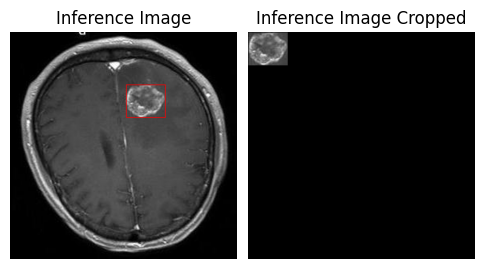

In [24]:
if result['bounding_box'] is not None:
    image = Image.open(image_path).resize((640, 640)) 
    inference_image_with_bbox = draw_bounding_box(image.copy(), result['bounding_box'])
    
    inference_image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(model.device)
    # Crop the neighbor image using the crop_and_resize function
    cropped_inference_image_tensor = model.crop_normalize_and_blackout(inference_image_tensor, [result['bounding_box']])
    # Convert the cropped tensor back to an image for visualization
    cropped_inference_image = transforms.ToPILImage()(cropped_inference_image_tensor.squeeze(0).cpu())
    
    # Display the original and cropped images side by side
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(inference_image_with_bbox)
    axes[0].set_title("Inference Image")
    
    axes[0].axis('off')
    
    axes[1].imshow(cropped_inference_image, cmap='gray')
    axes[1].set_title("Inference Image Cropped")
    axes[1].axis('off')
    plt.subplots_adjust(wspace=0.05)
    plt.savefig('/home/alan/Documents/YOLOV8_interpretable/images_and_graphs/' + img_num + '_inference.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

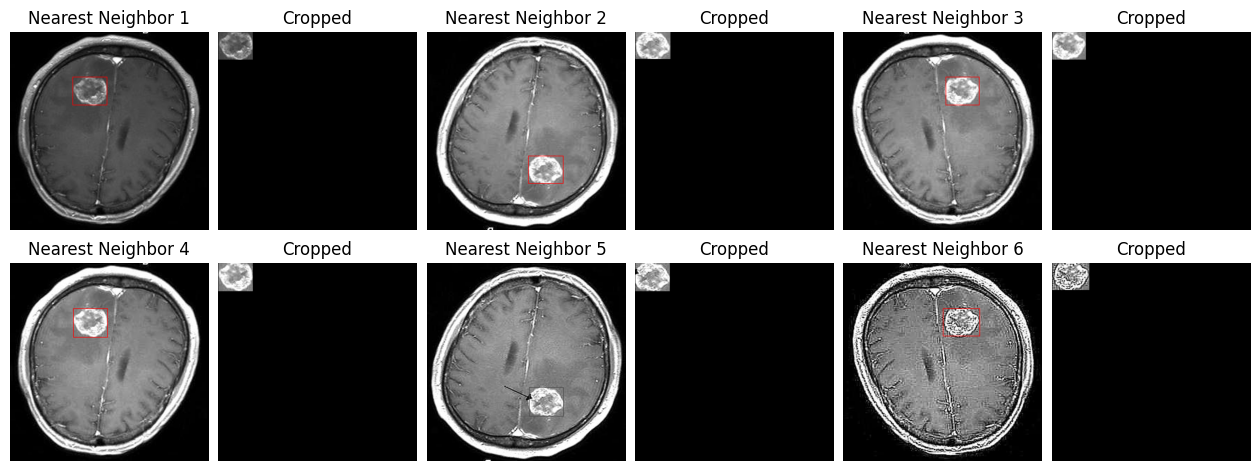

In [25]:
nearest_neighbors = result['nearest_neighbors']
i = 1
j = 0
k = 0
fig, axes = plt.subplots(2, 6, figsize=(16, 8))
for neighbor in nearest_neighbors:
    neighbor_image_path = os.path.join(model.train_loader.dataset.img_dir, neighbor)
    neighbor_image = Image.open(neighbor_image_path).resize((640, 640))


    neighbor_bbox = get_bounding_box_from_label(neighbor, label_dir)
    neighbor_image_with_bbox = draw_bounding_box(neighbor_image.copy(), neighbor_bbox)  # Use a copy to draw the bounding box


    # Convert the neighbor image to a tensor
    neighbor_image_tensor = transforms.ToTensor()(neighbor_image).unsqueeze(0).to(model.device)
    
    # Crop the neighbor image using the crop_and_resize function
    cropped_neighbor_image_tensor = model.crop_normalize_and_blackout(neighbor_image_tensor, [neighbor_bbox])
    
    # Convert the cropped tensor back to an image for visualization
    cropped_neighbor_image = transforms.ToPILImage()(cropped_neighbor_image_tensor.squeeze(0).cpu())

    
    # Display the original and cropped images side by side

    axes[j,k].imshow(neighbor_image_with_bbox, cmap='gray')
    axes[j,k].set_title(f"Nearest Neighbor {i}")
    axes[j,k].axis('off')
    
    axes[j,k+1].imshow(cropped_neighbor_image, cmap='gray')
    axes[j,k+1].set_title(f"Cropped")
    axes[j,k+1].axis('off')
    i += 1
    if(k >=4):
        j=1
        k=0
    else:
        k += 2
plt.subplots_adjust(wspace=0.05,hspace=-0.4)
plt.savefig('/home/alan/Documents/YOLOV8_interpretable/images_and_graphs/'+ img_num +'_neighbors.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

